# Gravner-Griffeath Snowflakes

Simulating snowflake growth based on the algorithm presented in:

[Modeling Snow Crystal Growth II: A mesoscopic lattice map with plausible dynamics.](http://psoup.math.wisc.edu/papers/h2l.pdf)  
Janko Gravner & David Griffeath (2007) - [doi:10.1016/j.physd.2007.09.008](http://dx.doi.org/10.1016/j.physd.2007.09.008).

#### Abstract 
We present a local lattice model for the evolution of snow crystals that combines diffusion-limited aggregation with anisotropic attachment kinetics and an idealized quasi-liquid layer.

#### Alternative Abstract
If you squint hard enough, snowflakes look like Conway's Game of Life.

In [1]:
import time
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage.interpolation import affine_transform
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def convolve(array, kernel):
    return convolve2d(array, kernel, boundary='symm', mode='same')

## The grid

Our simulation takes place on a hexagonal grid. We need to assigning each "site" in that grid a 2D coordinate, so that we can store the grid in an array.

There are [multiple coordinate systems for hexagonal grids](https://www.redblobgames.com/grids/hexagons/#coordinates), each with different tradeoffs. We're going to use "axial coordinates", which are just cartesian coordinates with the y axis rotated 30°.

![Axial Coordinates](images/coordinates.png)

## Neighbours on hex grids

  
![Hexagonal Neighbours](images/neighbours.png)

There are two sites which are neighbours of (0,0) on a square grid but not on a hexagonal grid: (1,1) and (-1,-1).

It turns out that ignoring those two sites when looking for neighbours is the only important difference between simulating square and hexagonal cellular automata.

In [2]:
# Construct a 3*3 array containing 1's for the centre site and all of its
# neighbours in a hex grid. 0's for sites which are not neighbours.
neighbourhood = np.full((3,3), 1)
neighbourhood[0,0] = 0
neighbourhood[2,2] = 0

## The state

In GoL there is a single bit of state for each site. The site is either alive (1) or dead (0).

Our snowflake algorithm keeps track of 4 variables for each site:
- "Is this site part of the snowflake?"
- Mass of ice present in the site
- Mass of liquid water present in the site
- Mass of water vapour in the site

The first of those is a boolean. The three masses are small positive floating point numbers.

In the paper those variables are given the following names:

- attachment - "Is this site part of the snowflake?"
- crystal mass - ice 
- boundary mass - liquid water
- diffusing mass - water vapour

In a stunning "coincidence" this allows them to use the abbreviations: a,b,c,d

## Initial state

At the start of the algorithm there is a single site in the centre of the grid which acts as a seed for the flake:
- a = True (attached)
- c = 1.0 (ice mass = 1)
- b = d = 0.0 (no water or vapour mass)

Every other site in the grid is filled with a configurable amount of water vapour. We'll call this initial water vapour density **ρ** (rho):
- a = False (not attached)
- d = **ρ** (configurable amount of water vapour)
- b = c = 0.0 (no water or ice mass)

In [3]:
def initial_state(size, rho):
    """ Create the initial state of the simulation.
    
    The return value is 4 2D `size`*`size` numpy arrays.
    """
    # Fill the grid with `rho` water vapour 
    a = np.full((size,size), False)
    b = np.full((size,size), 0.0)
    c = np.full((size,size), 0.0)
    d = np.full((size,size), rho) 
    
    # Create the snowflake seed in the middle of the grid
    midpoint = size//2
    a[midpoint,midpoint] = True
    c[midpoint,midpoint] = 1
    d[midpoint,midpoint] = 0
    
    return (a,b,c,d)

## Boundary layer

At various points in the simulation, interesting stuff happens at the boundary of the crystal.

This "boundary layer" is defined as sites which are not attached to the crystal (a=0) but which have one or more neighbours which are attached (a=1).

In [4]:
boundary_kernel = neighbourhood.copy()
boundary_kernel[1,1]= -7

def get_boundary(a):
    neighbours = convolve(a, boundary_kernel)
    np.clip(neighbours, 0, 7, neighbours)
    boundary = np.clip(neighbours, 0, 1)
    return (boundary, neighbours)

## The algorithm

Each generation of the algorithm is divided into 4 or 5 sub-steps representing different physical processes acting on the snowflake. These steps are all done in-order in every generation of the simulation.

1. Diffusion
2. Freezing
3. Attachment
4. Melting
5. Noise (optional)

I have not implemented the noise step. If implemented it would act to make the algorithm non-deterministic and the snowflakes non-symmetrical.

## The parameters

Without the noise step the algorithm is entirely deterministic and the shape of the final snowflake depends only on:
- the size of the grid
- the number of generations the simulation is run for
- 7 numeric parameters: **ρ** (rho), **κ** (kappa), **β** (beta), **α** (alpha), **θ** (theta), **μ** (mu) and **γ** (gamma)

We've seen **ρ** already as the initial vapour density. The other parameters will be explained in the sub-steps which use them.

### Step 1 - Diffusion

Replace the vapour mass in each site with the average of the vapour masses in that site and its 6 neighbours.

This models the way that gasses - such as water vapour - move away from regions with high concentrations and towards regions with low concentrations until they becomes evenly distributed.

The boundary of the crystal has a couple of special considerations:
- The vapour never diffuses into the crystal
- Any terms for neighbours in the crystal are replaced by the vapour mass for the site itself - *Reflecting boundary conditions*

In [5]:
diffusion_kernel = neighbourhood/7

def diffusion(a, b, c, d, neighbours):
    # The basic diffusion formula is a hexagonal box blur convolution.
    # The boundary of the crystal has a couple of special considerations:
    # - The vapour never diffuses into the crystal - This is handled by the
    #   "*np.invert(a)" term
    # - Any terms for neighbours in the crystal are replaced by the vapour mass
    #   for the site itself - This is handled by the " + neighbours*d/7" term 
    d = convolve(d, diffusion_kernel)*np.invert(a) + neighbours*d/7
    
    return (a, b, c, d)


### Step 2 - Freezing

Proportion **κ** (kappa) of the vapour mass at each boundary site crystallises into solid mass. The remainder (proportion 1 − **κ**) condenses into liquid mass. This leaves no vapour mass at any boundary site.

Note that while the paper describes this step as freezing, it actually models deposition (gas → solid) and condensation (gas → liquid) but not freezing (liquid → solid).

In [6]:
def freezing(a, b, c, d, boundary, kappa):
    # Proportion κ (kappa) of the vapour mass at each boundary site crystallises
    # into solid mass. The remainder (proportion 1−κ) condenses into liquid mass
    b += boundary * d * (1-kappa)
    c += boundary * d * kappa
    d -= boundary * d
    
    return (a, b, c, d)


### Step 3 - Attachment

This key step in the algorithm decides when a boundary site joins the snowflake crystal. The conditions under which a boundary site x attaches to the crystal depends the number of neighbours of x which are already attached.

- A boundary site with 1 or 2 attached neighbours needs liquid mass at least **β** (beta) to join the crystal.
- A boundary site with 3 attached neighbours joins the crystal if either
    - it has liquid mass ≥ 1, or
    - it has liquid mass ≥ **α** (alpha) and there is a total vapour mass < **θ** (theta) in its neighbourhood.
- A boundary site with 4 or more attached neighbours joins the crystal automatically.

Once a site becomes attached all of the liquid mass in that site freezes to ice.

In [7]:
def attachment(a, b, c, d, neighbours, boundary, beta, alpha, theta):
    # 3a - A boundary site with 1 or 2 attached neighbours needs boundary mass
    #      at least β to join the crystal:
    a |= ((neighbours == 1) | (neighbours == 2)) & (b >= beta)

    # 3b - A boundary site with 3 attached neighbours joins the crystal if
    #      it has boundary mass ≥ 1
    a |= (neighbours == 3) & (b >= 1)
    
    #      or it has diffusive mass < θ in its neighbourhood and it has boundary
    #      mass ≥ α:
    nearby_diffusive_mass = convolve(d, neighbourhood)
    a |= (neighbours == 3) & (b >= alpha) & (nearby_diffusive_mass < theta)

    # 3c - Boundary sites with 4 or more attached neighbours join the crystal
    #      automatically
    a |= (neighbours >= 4)

    # Once a site is attached, its boundary mass becomes crystal mass:
    c += boundary*a*b
    b -= boundary*a*b

    return (a, b, c, d)


### Step 4 - Melting

Proportion **μ** (mu) of the liquid mass and proportion **γ** (gamma) of the solid mass at each boundary site become vapour.

As with the freezing step this is badly named. There is no melting (solid → liquid) being modelled, only vaporisation (liquid → gas) and sublimation (solid → gas).

In [8]:
def melting(a, b, c, d, boundary, mu, gamma):
    # Proportion μ of the boundary mass and proportion γ of the crystal mass
    # at each boundary site become diffusive mass. 
    d += boundary * (b*mu + c*gamma)
    b -= boundary * b*mu
    c -= boundary * c*gamma

    return (a, b, c, d)


## Putting it all together

Lets create a `Snowflake` class to wrap the arrays (a, b, c, d), the params (rho, kappa, beta, alpha, theta, mu, gamma) and a few other bits and pieces into a single object.

We'll give it the following API:
- snowflake = Snowflake(size, rho, kappa, beta, alpha, theta, mu, gamma)
- snowflake.run(generations)  
- snowflake.run_with_feedback(generations, yield_every=1000)  
- snowflake.save_to_file(file_path)  
- snowflake = Snowflake.load_from_file(file_path)  


In [9]:
class Snowflake:
    def __init__(self, size, rho, kappa, beta, alpha, theta, mu, gamma):
        self.size = size
        self.rho = rho
        self.kappa = kappa
        self.beta = beta
        self.alpha = alpha
        self.theta= theta
        self.mu = mu
        self.gamma = gamma
        
        (a,b,c,d) = initial_state(self.size, self.rho)
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
        self.generation = 0
        
    
    def run_with_feedback(self, generations, yield_every=1000):
        (a,b,c,d) = (self.a,self.b,self.c,self.d)
        (boundary, neighbours) = get_boundary(a)

        for x in range(1, generations+1):
            (a,b,c,d) = diffusion(a, b, c, d, neighbours)
            (a,b,c,d) = freezing(a, b, c, d, boundary, self.kappa)
            (a,b,c,d) = attachment(a, b, c, d, neighbours, boundary, self.beta, self.alpha, self.theta)
            # The attachment step changes `a` so we need to recalculate `boundary` and `neighbours`
            (boundary, neighbours) = get_boundary(a)
            (a,b,c,d) = melting(a, b, c, d, boundary, self.mu, self.gamma)
            
            (self.a,self.b,self.c,self.d) = (a,b,c,d)
            self.generation += 1

            if x%yield_every == 0:
                yield self
        if x%yield_every != 0:
             yield self
    
    
    def run(self, generations):
        for _ in self.run_with_feedback(generations, yield_every=generations+1):
            pass
    
    
    def save_to_file(self, file_path):
        params = dict(
            size = self.size,
            generations = self.generations,
            rho = self.rho,
            kappa = self.kappa,
            beta = self.beta,
            alpha = self.alpha,
            theta= self.theta,
            mu = self.mu,
            gamma = self.gamma,
            sigma = 0, # Currently unused
        )
        np.savez_compressed(file_path, a=self.a, b=self.b, c=self.c, d=self.d, params=params)
        
    
    @classmethod
    def load_from_file(self, file_path):
        raise NotImplementedError()

## Visualisation

Rendering the snowflake as an image involves a few steps:
1. Take the 4 arrays (a,b,c,d) and convert them into a single array containing one numeric value per site.
    - The value is in the range (-1 ≤ v ≤ 1)
    - Positive values mean inside the crystal (a=1). Larger numbers represent greater crystal mass (c)
    - Negative values mean outside of the crystal (a=0). Larger numbers represent greater vapour mass (d)
2. Affine transform that "image" to a hexagonal grid
    - Sheer the vertical axis over 30 deg
    - Squash vertically by a factor of √3/2
    - Use bicubic interpolation to keep the transformed "image" smooth
3. Plot that "image" as an actual image. Apply a colourmap to convert each value to a colour
    - Positive values get shades of blue, larger values get darker blue
    - Negative values get shades of grey, larger (more-negative) values get darker grey

In [10]:
sheer_30_degrees = np.matrix([[1, 0, 0], [-0.5, 1, 0], [0, 0, 1]])
squash = np.matrix([[2/(3**0.5), 0, 0], [0, 1, 0], [0, 0, 1]])

def get_image(snowflake):
    # Merge vapour and ice fields into a single normalised value for each site which ranges from -1 to 1
    # -1 = Not attached and vapour mass is maximum
    # 0 = (Not attached and 0 vapour mass) or (attached and 0 ice mass)
    # 1 = Attached and maximum ice mass
    background = np.invert(snowflake.a) * snowflake.d/np.max(snowflake.d)
    flake = snowflake.a * (snowflake.c/np.max(snowflake.c))
    image = flake - background

    # Transform to hexagonal grid by sheering the vertical axis over 30 deg and then squashing vertically 
    translate_to_origin = np.matrix([[1, 0, snowflake.size/2], [0, 1, snowflake.size/2], [0, 0, 1]])
    translate_to_centre = np.matrix([[1, 0, -snowflake.size/2], [0, 1, -snowflake.size/2], [0, 0, 1]])
    convolution = translate_to_origin * sheer_30_degrees * squash * translate_to_centre
    return affine_transform(image, convolution, cval=-1)


In [11]:
snowflake_colour_map = LinearSegmentedColormap(
    "",
    {'red':   ((0.0, 0.80, 0.80),
               (0.5, 1.00, 0.80),
               (1.0, 0.05, 0.05)),

     'green': ((0.0, 0.80, 0.80),
               (0.5, 1.00, 1.00),
               (1.0, 0.15, 0.15)),

     'blue':  ((0.0, 0.80, 0.80),
               (0.5, 1.00, 1.00),
               (1.0, 0.55, 0.55))
    }
)


In [12]:
def render_image(snowflake_image, size):
    fig, ax = plt.subplots(1, 1, figsize=(size,size))
    ax.imshow(snowflake_image, cmap=snowflake_colour_map)
    ax.set_axis_off()
    plt.show()

    
def render(snowflake, size=12):
    render_image(get_image(snowflake), size=size)


## Debug Visualisation

`render()` is good for creating a final image. But it's also useful to have lower level visualisation of what's going on inside the simulation. That's what `visualise()` provides. It compactly renders each of the four arrays (a,b,c,d) individually without applying any affine transformation.

I recommend calling `visualise()` inside a `snowflake.run_with_feedback(...)` loop.

In [13]:
def visualise(snowflake):
    fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(17,3))
    axs[0].imshow(snowflake.d, origin='lower', clim=(0.0, 1.0))
    axs[1].imshow(snowflake.b, origin='lower', clim=(0.0, 1.0))
    axs[2].imshow(snowflake.c, origin='lower', clim=(0.0, 1.0))
    i = axs[3].imshow(snowflake.a, origin='lower', clim=(0.0, 1.0))
    axs[0].set_title("Vapour")
    axs[1].set_title("Water")
    axs[2].set_title("Ice")
    axs[3].set_title("Attachment")
    cb = fig.colorbar(i, ax=axs)
    plt.show()


In [14]:
s = Snowflake(
    size = 701,
    rho = 0.635,
    kappa = 0.005,
    beta = 1.6,
    alpha = 0.4,
    theta= 0.025,
    mu = 0.015,
    gamma = 0.0005,
)
start = time.time()
for progress in s.run_with_feedback(generations=7000, yield_every=1000):
    timestamp = time.strftime("%H:%M:%S", time.gmtime(time.time()-start))
    print(f'{timestamp} - Generation {progress.generation}')


00:02:07 - Generation 1000
00:04:15 - Generation 2000
00:06:27 - Generation 3000
00:08:35 - Generation 4000
00:10:44 - Generation 5000
00:12:51 - Generation 6000
00:15:03 - Generation 7000


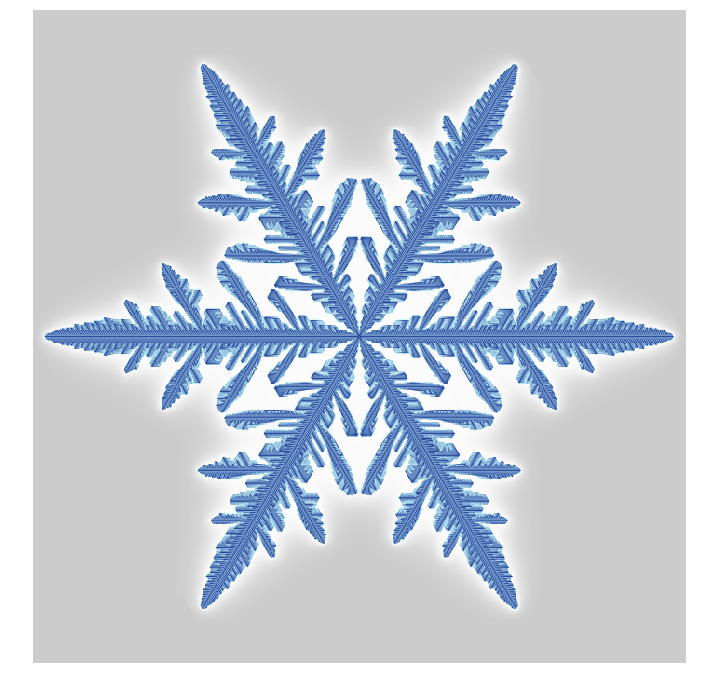

In [15]:
render(s)